In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from tqdm import tqdm
from scipy.optimize import curve_fit
import pandas as pd
import datetime as dt
from IPython.display import clear_output
plt.style.use('ggplot')
pd.set_option('float_format', '{:f}'.format)
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
import numpy as n
import scipy.interpolate
import scipy.ndimage

def congrid(a, newdims, method='linear', centre=False, minusone=False):
    '''Arbitrary resampling of source array to new dimension sizes.
    Currently only supports maintaining the same number of dimensions.
    To use 1-D arrays, first promote them to shape (x,1).
    
    Uses the same parameters and creates the same co-ordinate lookup points
    as IDL''s congrid routine, which apparently originally came from a VAX/VMS
    routine of the same name.

    method:
    neighbour - closest value from original data
    nearest and linear - uses n x 1-D interpolations using
                         scipy.interpolate.interp1d
    (see Numerical Recipes for validity of use of n 1-D interpolations)
    spline - uses ndimage.map_coordinates

    centre:
    True - interpolation points are at the centres of the bins
    False - points are at the front edge of the bin

    minusone:
    For example- inarray.shape = (i,j) & new dimensions = (x,y)
    False - inarray is resampled by factors of (i/x) * (j/y)
    True - inarray is resampled by(i-1)/(x-1) * (j-1)/(y-1)
    This prevents extrapolation one element beyond bounds of input array.
    '''
    if not a.dtype in [n.float64, n.float32]:
        a = n.cast[float](a)

    m1 = n.cast[int](minusone)
    ofs = n.cast[int](centre) * 0.5
    old = n.array( a.shape )
    ndims = len( a.shape )
    if len( newdims ) != ndims:
        print("[congrid] dimensions error. " \
              "This routine currently only support " \
              "rebinning to the same number of dimensions.")
        return None
    newdims = n.asarray( newdims, dtype=float )
    dimlist = []

    if method == 'neighbour':
        for i in range( ndims ):
            base = n.indices(newdims)[i]
            dimlist.append( (old[i] - m1) / (newdims[i] - m1) \
                            * (base + ofs) - ofs )
        cd = n.array( dimlist ).round().astype(int)
        newa = a[list( cd )]
        return newa

    elif method in ['nearest','linear']:
        # calculate new dims
        for i in range( ndims ):
            base = n.arange( newdims[i] )
            dimlist.append( (old[i] - m1) / (newdims[i] - m1) \
                            * (base + ofs) - ofs )
        # specify old dims
        olddims = [n.arange(i, dtype = n.float) for i in list( a.shape )]

        # first interpolation - for ndims = any
        mint = scipy.interpolate.interp1d( olddims[-1], a, kind=method )
        newa = mint( dimlist[-1] )

        trorder = [ndims - 1] + range( ndims - 1 )
        for i in range( ndims - 2, -1, -1 ):
            newa = newa.transpose( trorder )

            mint = scipy.interpolate.interp1d( olddims[i], newa, kind=method )
            newa = mint( dimlist[i] )

        if ndims > 1:
            # need one more transpose to return to original dimensions
            newa = newa.transpose( trorder )

        return newa
    elif method in ['spline']:
        oslices = [ slice(0,j) for j in old ]
        oldcoords = n.ogrid[oslices]
        nslices = [ slice(0,j) for j in list(newdims) ]
        newcoords = n.mgrid[nslices]

        newcoords_dims = range(n.rank(newcoords))
        #make first index last
        newcoords_dims.append(newcoords_dims.pop(0))
        newcoords_tr = newcoords.transpose(newcoords_dims)
        # makes a view that affects newcoords

        newcoords_tr += ofs

        deltas = (n.asarray(old) - m1) / (newdims - m1)
        newcoords_tr *= deltas

        newcoords_tr -= ofs

        newa = scipy.ndimage.map_coordinates(a, newcoords)
        return newa
    else:
        print("Congrid error: Unrecognized interpolation type.\n", \
              "Currently only \'neighbour\', \'nearest\',\'linear\',", \
              "and \'spline\' are supported.")
        return None

# Plot Maker!

In [2]:
%matplotlib qt5
%run plot_maker
%matplotlib inline

new_x = [i[0] for i in coords]
new_y = [i[1] for i in coords]

Array of x values: 
 [0.26881720430107947, 3.7634408602150557, 8.602150537634412, 14.919354838709683, 14.919354838709683, 21.236559139784955, 25.537634408602155, 29.03225806451614, 29.03225806451614, 34.2741935483871, 35.48387096774195, 38.30645161290323, 41.935483870967744, 46.639784946236574, 49.327956989247326, 53.09139784946238, 56.85483870967744, 60.21505376344088, 63.306451612903246, 63.306451612903246, 67.33870967741937, 72.31182795698926, 76.20967741935486, 77.28494623655915, 79.03225806451614, 83.06451612903227, 86.6935483870968, 90.32258064516131, 90.32258064516131, 96.3709677419355, 97.84946236559142, 98.1182795698925, 99.32795698924733]
Array of y values: 
 [59.5352016404648, 1.5721120984278905, 2.1189336978810687, 3.7593984962406033, 3.7593984962406033, 5.673274094326729, 7.313738892686263, 6.493506493506494, 6.493506493506494, 5.399863294600138, 4.579630895420372, 4.579630895420372, 3.7593984962406033, 3.7593984962406033, 5.126452494873551, 7.860560492139442, 11.141490088

In [2]:
#Do you want to save these points?
#np.save('astar_custom6_'+str(dt.datetime.now()).strip().replace(' ','').replace(':','.'),[new_x,new_y],allow_pickle=1)
#to load it again: [x,y] = np.load('filename')

In [3]:
human_astar_life_ratio = 100/1000
human_waith_life_ratio = 100/25000

# BACK END

In [4]:
#from poppyr_header import pre_sim_process
%run poppyr_header.py

# FRONT END

## Roman Mortality

Processed data:
Total population:  100000.00000000004
Birth rate:  0.040925825344664275
Death rate:  0.038611063053949284
Growth rate in percent:  0.23147622907149878
Estimated life expectancy after 1 year:  28.58877348670154
Astar-to-Human equiv:  2.858877348670154
Waith-to-Human equiv:  0.11435509394680617


Raw data:
Total population:  100000.00000000001
Birth rate:  0.20160423890447476
Death rate:  0.197900269437729
Growth rate in percent:  0.37039694667457657


,Age,Mortality,Cohort,Reach Probability,Life Expectancy
0,0.000000,13.605540,100000.000000,1.000000,25.640503
1,1.010101,12.030563,86394.459873,0.863945,28.588773
2,2.020202,10.434531,76000.720029,0.760007,31.419359
3,3.030303,8.613176,68070.401488,0.680704,34.010828
4,4.040404,6.693869,62207.377775,0.622074,36.158634
5,5.050505,5.042144,58043.297190,0.580433,37.706355
6,6.060606,3.706774,55116.670703,0.551167,38.671597
7,7.070707,2.735532,53073.620400,0.530736,39.130703
8,8.080808,2.027502,51621.774476,0.516218,39.206937
9,9.090909,1.506017,50575.142077,0.505751,38.997756


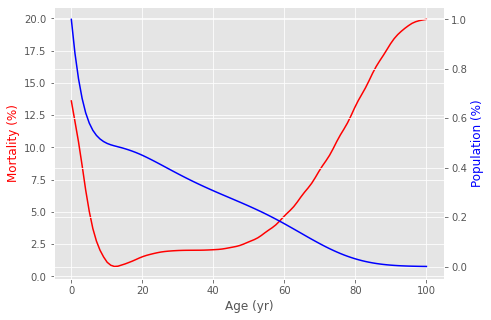

In [4]:
#array of roman ages to correspond with roman mortality rates
roman_ages = [0,1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]
roman_mort = [30,22,6,5,6,8,9,10,11,11,12,15,19,27,35,47,61,73,87,95,100]

#If we smash together the 1 + 5 cohorts to an average of 35% mortality it makes the array
#easier to work with since the spaces are normalized.
rma = [np.sum([30,22]),6,5,6,8,9,10,11,11,12,15,19,27,35,47,61,73,87,95,100] #roman mort adjusted
#rma = [46,6,5,6,8,9,10,11,11,12,15,19,27,35,47,61,73,87,95,100] #roman mort adjusted
raa = np.linspace(0,95,20) #roman ages adjusted

print("Processed data:")
ages = raa
mortality = rma
lifetime = 100
fertility_start = 12
fertility_end = 49
TF_guess = 4.9
curve_degree = 3
cohort_len = 1
flat_fertility_pdf = 0
customfactor = 1
verbose = 0
roman_expanded_presim = pre_sim_process(ages,mortality,lifetime,fertility_start,fertility_end,
                                     TF_guess,curve_degree,cohort_len,flat_fertility_pdf,
                                     customfactor,verbose)
#[ages_final,mortality_final,I,d,e,[pop,total_deaths,new_births,r],lifetable]

################
#Let's do it with the non expanded data and compare them.
print("\n\nRaw data:")
[roman_I,roman_deaths,roman_e] = get_population_distribution(rma,raa)
roman_lifetable = pd.DataFrame(data=(raa,rma,roman_I,roman_e),index=('Age','Mortality','Cohort','Life Expectancy'))

#Raw data
placeholder = estimate_statistics(roman_I,rma,raa,roman_deaths,fertility_start=18,fertility_end=45,TF_guess=5.5)
#roman_lifetable.transpose()

roman_expanded_presim[-1].transpose()[0:21]

#print(roman_expanded_presim[-1])

Final growth rate:  0.104 %
Final birth rate:  0.03970805771016194
Final death rate:  0.03867079971580494
Final population:  275751.0485433578
Half population below:  24  years
Half pop below (astar):  2.4000000000000004
Half pop below (waith):  0.096
TF final value:  4.7257049227741055


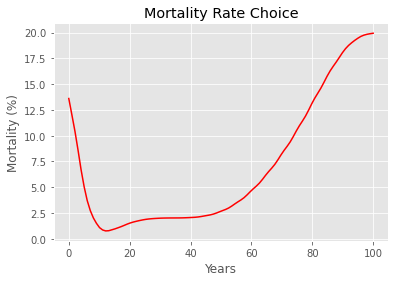

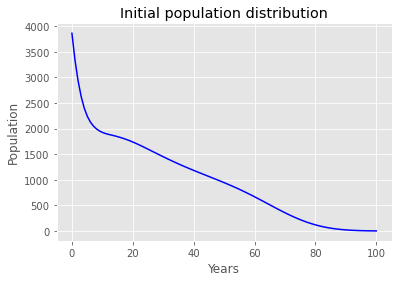

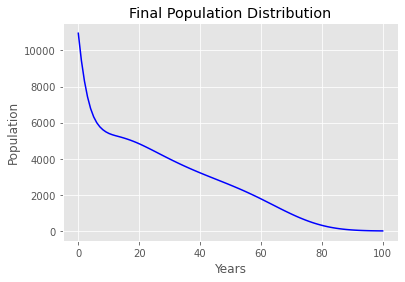

In [5]:
# roman_expanded_result = np.load('roman_expanded_12021-01-1412.28.57.426426.npy',allow_pickle=1)
    
# #Raw Roman Data
# main_sim(raa,np.array(rma),12,32,population_distribution=np.zeros(len(rma))+1e3
#          ,predict=1,guess_TF=3,set_growth_rate=(0.1/100),TF_set=5.33,sim_len=None,print_flag=0)

# #Expanded Roman Data
ages = roman_expanded_presim[0]
mortality = roman_expanded_presim[1]
pop_d = roman_expanded_presim[2]*1e5
fertility_start = 12
fertility_end = 49
predict_TF = 1
guess_TF = 6
set_growth_rate = (0.1/100)
set_TF = 6
flat_fertility_pdf = 0
sim_len = 300
print_flag = 0
final_report = 1
savefile = None


roman_expanded_mainsim = main_sim(ages,mortality,pop_d,fertility_start,fertility_end,
                                  predict_TF,guess_TF,set_growth_rate,set_TF,flat_fertility_pdf,
                                  sim_len,print_flag,final_report,savefile)    
#[final_pop_d,pop_d,half_pop_below,TF,growth_rate,birth_rate,death_rate]

94.9035277634389


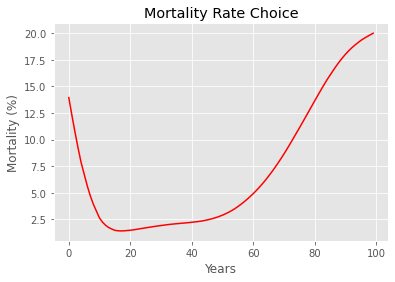

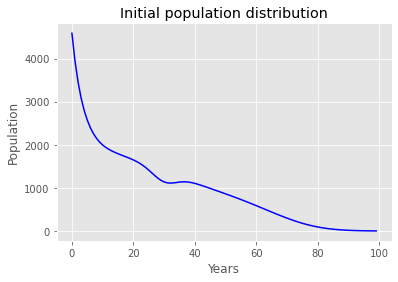

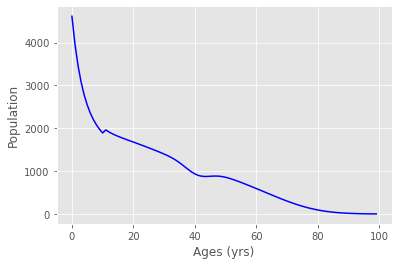

In [7]:
pop_mainsim = roman_expanded_mainsim
pop_presim = roman_expanded_presim
init_pop = 1e5
lifetime = 100
total_war_casualties = init_pop*0.1*(0.25)
average_warrior_age = 30
warrior_age_spread = 8
recovery_time = 11
fertility_start = 18
fertility_end = 45
birth_rate_mod = -0

percentage_recovered = war_recovery(pop_mainsim,pop_presim,init_pop,lifetime,
                                    total_war_casualties,average_warrior_age,warrior_age_spread,
                                    recovery_time,fertility_start,fertility_end,birth_rate_mod)

print(percentage_recovered)

In [11]:
roman_expanded_presim[0]

array([  0.        ,   1.01010101,   2.02020202,   3.03030303,
         4.04040404,   5.05050505,   6.06060606,   7.07070707,
         8.08080808,   9.09090909,  10.1010101 ,  11.11111111,
        12.12121212,  13.13131313,  14.14141414,  15.15151515,
        16.16161616,  17.17171717,  18.18181818,  19.19191919,
        20.2020202 ,  21.21212121,  22.22222222,  23.23232323,
        24.24242424,  25.25252525,  26.26262626,  27.27272727,
        28.28282828,  29.29292929,  30.3030303 ,  31.31313131,
        32.32323232,  33.33333333,  34.34343434,  35.35353535,
        36.36363636,  37.37373737,  38.38383838,  39.39393939,
        40.4040404 ,  41.41414141,  42.42424242,  43.43434343,
        44.44444444,  45.45454545,  46.46464646,  47.47474747,
        48.48484848,  49.49494949,  50.50505051,  51.51515152,
        52.52525253,  53.53535354,  54.54545455,  55.55555556,
        56.56565657,  57.57575758,  58.58585859,  59.5959596 ,
        60.60606061,  61.61616162,  62.62626263,  63.63

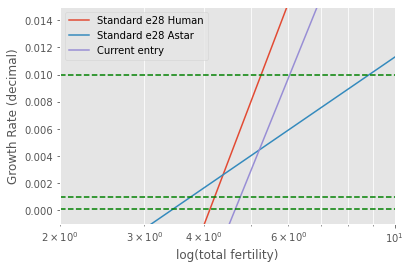

In [12]:
ages = roman_expanded_presim[0]
mortality = roman_expanded_presim[1]
pop_d = roman_expanded_presim[2]*1e5
fertility_start = 18
fertility_end = 45
flat_fertility_pdf = 0
sim_len = 300
final_report = 1
special_step = np.arange(0.1,15,0.5)
savefile = None#"tfvsr_roman"

roman_expanded_tfvsr = get_tf_vs_r(ages,mortality,pop_d,fertility_start,fertility_end,
                                      flat_fertility_pdf,
                                      sim_len,final_report,special_step,savefile)

In [13]:
roman_tfvsr = np.load("tfvsr_roman2022-08-2819.29.47.455822.npy")
(roman_tfvsr[0]*np.log(5.85)+roman_tfvsr[1])*100

0.09406742522704153

In [16]:
#For astar:
astar_roman_tfvsr = np.load("tfvsr_astar_roman_2021-04-2014.28.51.490896.npy")
(astar_roman_tfvsr[0]*np.log(6)+astar_roman_tfvsr[1])*100

0.5029081610805848

## Nigerian Data

### Female mortality

Total population:  100000.0
Birth rate:  0.05642187546528278
Death rate:  0.03912463179681642
Growth rate in percent:  1.7297243668466367
Estimated life expectancy after 1 year:  26.59086920929189
Astar-to-Human equiv:  2.659086920929189
Waith-to-Human equiv:  0.10636347683716756


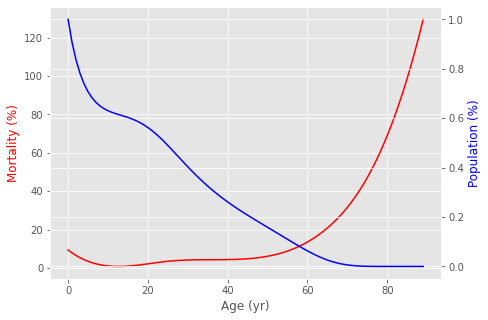

In [63]:
early_nigerian_mortality_w = np.sum([0.062,0.041])
nigerian_mortality_raw_w = np.array([0.062,0.041,0.017,0.009,0.021,0.026,0.032,0.036,0.044,0.047,0.049,0.061,0.08,0.135,0.208,0.327,0.483,0.663,1])
nigerian_mortality_adj_w = np.array([early_nigerian_mortality_w,0.017,0.009,0.021,0.026,0.032,0.036,0.044,0.047,0.049,0.061,0.08,0.135,0.208,0.327,0.483,0.663,1])*100
nigerian_ages_w = np.linspace(0,85,18)

ages = nigerian_ages_w
mortality = nigerian_mortality_adj_w
lifetime = 90
fertility_start = 15
fertility_end = 45
TF_guess = 5.67
curve_degree = 3
cohort_len = 1
flat_fertility_pdf = 0
customfactor = 5
verbose = 0
nigerian_w_presim = pre_sim_process(ages,mortality,lifetime,fertility_start,fertility_end,
                                     TF_guess,curve_degree,cohort_len,flat_fertility_pdf,
                                     customfactor,verbose)
#ages_final,mortality_final,(I/sum(I)),d,e,[pop,total_deaths,new_births,r],lifetable

#nigerian_w_all[-1].transpose()

### Male mortality

Total population:  99999.99999999999
Birth rate:  0.04273981689013167
Death rate:  0.017649211821238055
Growth rate in percent:  2.5090605068893614
Estimated life expectancy after 1 year:  55.34129688664829
Astar-to-Human equiv:  5.534129688664829
Waith-to-Human equiv:  0.22136518754659315


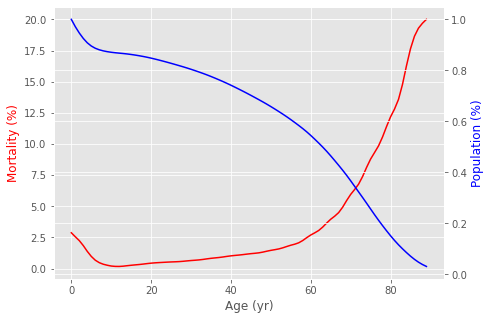

In [10]:
early_nigerian_mortality = np.sum([0.071,0.039])
nigerian_mortality_raw = np.array([0.071,0.039,0.013,0.007,0.017,0.025,0.028,0.035,0.045,0.055,0.063,0.079,0.102,0.153,0.223,0.339,0.496,0.671,1])
nigerian_mortality_adj = np.array([early_nigerian_mortality,0.013,0.007,0.017,0.025,0.028,0.035,0.045,0.055,0.063,0.079,0.102,0.153,0.223,0.339,0.496,0.671,1])*100
nigerian_ages = np.linspace(0,85,18)

ages = nigerian_ages
mortality = nigerian_mortality_adj
lifetime = 90
fertility_start = 15
fertility_end = 45
TF_guess = 5.67
curve_degree = 12
cohort_len = 1
flat_fertility_pdf = 0
customfactor = 1
verbose = 0
nigerian_presim = pre_sim_process(ages,mortality,lifetime,fertility_start,fertility_end,
                                     TF_guess,curve_degree,cohort_len,flat_fertility_pdf,
                                     customfactor,verbose)

Final growth rate:  1.002 %
Final birth rate:  0.025225179088729607
Final death rate:  0.01530392575855776
Final population:  570102.033544793
Half population below:  26  years
Half pop below (astar):  2.6
Half pop below (waith):  0.10400000000000001
TF final value:  3.1345891426332497


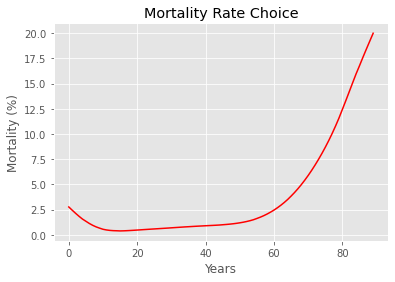

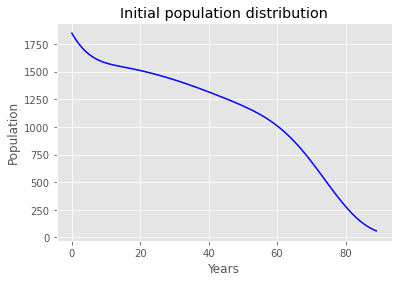

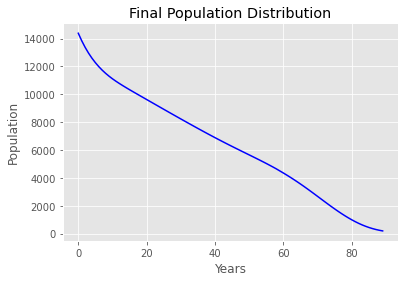

In [11]:

# #Nigeria, 2016, males
# main_sim(nigerian_all[0],nigerian_all[1],17,43,population_distribution=np.zeros(len(nigerian_all[1]))+1e3
#          ,predict=0,guess_TF=3,set_growth_rate=(0.1/100),TF_set=5.33,sim_len=None,print_flag=0)

# #Nigeria, 2016, females
# main_sim(nigerian_w_all[0],nigerian_w_all[1],17,43,population_distribution=np.zeros(len(nigerian_w_all[1]))+1e3
#          ,predict=1,guess_TF=3,set_growth_rate=(0.1/100),TF_set=5.33,sim_len=None,print_flag=0)

ages = nigerian_w_presim[0]
mortality = nigerian_w_presim[1]
pop_d = nigerian_w_presim[2]*1e5
fertility_start = 15
fertility_end = 45
predict_TF = 1
guess_TF = 3
set_growth_rate = (1/100)
set_TF = 5.67
flat_fertility_pdf = 0
sim_len = 200
print_flag = 0
final_report = 1
savefile = None

nigerian_w_mainsim = main_sim(ages,mortality,pop_d,fertility_start,fertility_end,
                                  predict_TF,guess_TF,set_growth_rate,set_TF,flat_fertility_pdf,
                                  sim_len,print_flag,final_report,savefile)
#[final_pop_d,pop_d,half_pop_below,TF,growth_rate,birth_rate,death_rate]

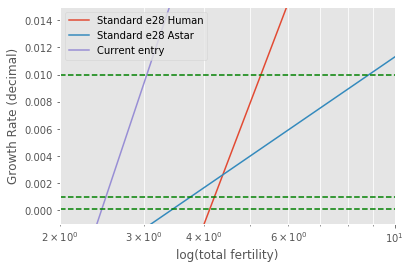

In [131]:
ages = nigerian_w_presim[0]
mortality = nigerian_w_presim[1]
pop_d = nigerian_w_presim[2]*1e5
fertility_start = 15
fertility_end = 45
flat_fertility_pdf = 0
sim_len = 300
final_report = 1
special_step = np.arange(1,15,1)
savefile = None

nigerian_w_tfvsr = get_tf_vs_r(ages,mortality,pop_d,fertility_start,fertility_end,
                                      flat_fertility_pdf,
                                      sim_len,final_report,special_step,savefile)

## Astar Data

### Based on Roman Data

In [17]:
#from poppyr_header import pre_sim_process
%run poppyr_header.py

Total population:  100000.00000000001
Birth rate:  0.003987548449861841
Death rate:  0.0038280599080205077
Growth rate in percent:  0.01594885418413338
Estimated life expectancy after 1 year:  263.55850806231894
Astar-to-Human equiv:  26.355850806231896
Waith-to-Human equiv:  1.0542340322492758


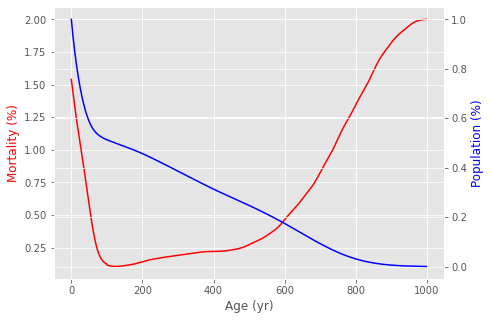

In [18]:
astar_ages = np.arange(0,1000,50) #20-length array to match original mortality


ages = astar_ages
mortality = rma
lifetime = 1000
fertility_start = 60
fertility_end = 180
TF_guess = 4
curve_degree = 12
cohort_len = 1
flat_fertility_pdf = 0
customfactor = 8
verbose = 0


astar_roman_presim = pre_sim_process(ages,mortality,lifetime,fertility_start,fertility_end,
                                     TF_guess,curve_degree,cohort_len,flat_fertility_pdf,
                                     customfactor,verbose);

Final growth rate:  0.1 %
Final birth rate:  0.004947921121971619
Final death rate:  0.00394506070350897
Final population:  2516582.654543483
Half population below:  193  years
Half pop below (astar):  19.3
Half pop below (waith):  0.772
TF final value:  4.216032703926365


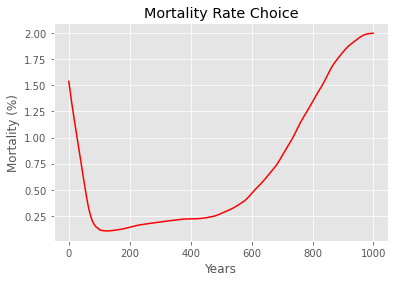

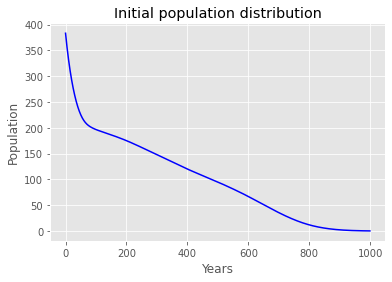

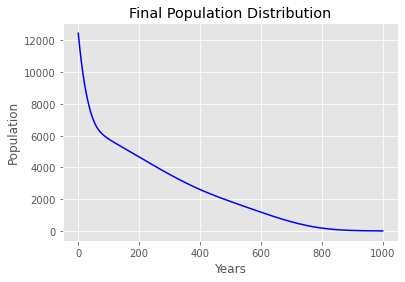

In [13]:
astar_roman_result = np.load('astar_roman_test12020-12-1415.19.29.172662.npy',allow_pickle=1)

# #Astar Data, based on Roman
ages = astar_roman_presim[0]
mortality = astar_roman_presim[1]
pop_d = astar_roman_presim[2]*1e5
fertility_start = 60
fertility_end = 180
predict_TF = 1
guess_TF = 6
set_growth_rate = (0.1/100)
set_TF = 4
flat_fertility_pdf = 0
sim_len = 2000
print_flag = 0
final_report = 1
savefile = None


astar_roman_mainsim = main_sim(ages,mortality,pop_d,fertility_start,fertility_end,
                                  predict_TF,guess_TF,set_growth_rate,set_TF,flat_fertility_pdf,
                                  sim_len,print_flag,final_report,savefile)

234.87294674740696

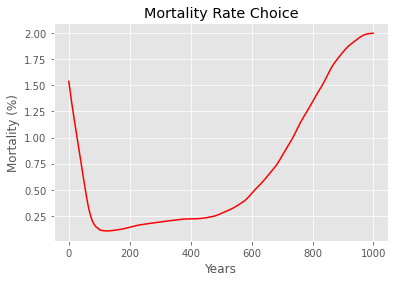

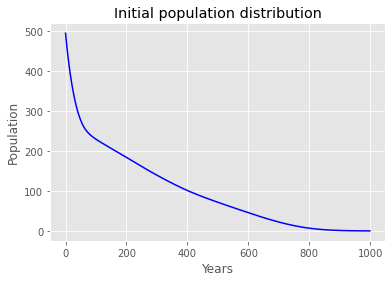

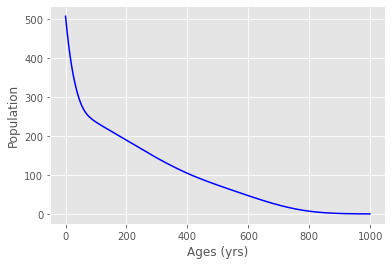

In [14]:
pop_mainsim = astar_roman_mainsim
pop_presim = astar_roman_presim
init_pop = 1e5
lifetime = 1000
total_war_casualties = init_pop*0.1*0.1
average_warrior_age = 400
warrior_age_spread = 350
recovery_time = 27
fertility_start = 60
fertility_end = 180
birth_rate_mod = -0
final_report=0

war_recovery(pop_mainsim,pop_presim,init_pop,lifetime,total_war_casualties,
             average_warrior_age,warrior_age_spread,recovery_time,
             fertility_start,fertility_end,birth_rate_mod,final_report)

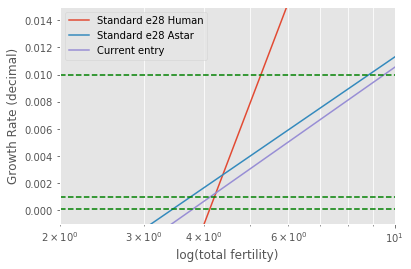

In [135]:
ages = astar_roman_presim[0]
mortality = astar_roman_presim[1]
pop_d = astar_roman_presim[2]*1e5
fertility_start = 60
fertility_end = 180
flat_fertility_pdf = 0
sim_len = 2000
final_report = 1
special_step = np.arange(1,15,1)
savefile = None#"tfvsr_astar_roman_"

astar_roman_tfvsr = get_tf_vs_r(ages,mortality,pop_d,fertility_start,fertility_end,
                                      flat_fertility_pdf,
                                      sim_len,final_report,special_step,savefile)

### Handmade

Total population:  100000.00000000013
Birth rate:  0.0041990477563895534
Death rate:  0.0038875537386271735
Growth rate in percent:  0.03114940177623801
Estimated life expectancy after 1 year:  267.2961464881506
Astar-to-Human equiv:  26.729614648815062
Waith-to-Human equiv:  1.0691845859526026


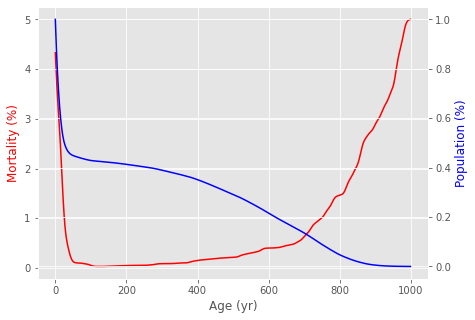

In [15]:
astar_mortality_handmade = np.array([60,10,2,2,1.55,0.6,0.6,0.65,0.8,0.9,1,
                                     1,1,1.2,1.7,1.75,1.75,2,2,2.8,
                                     3.2,3.5,3.8,4,4.2,4.3,5.4,6,6.5,8,
                                     8,8.2,9,9.5,11,14,18,20,24,29,
                                     29.5,36,41,52,55,60,66,72,88,100])

astar_ages_handmade = np.arange(0,1000,len(astar_mortality_handmade))


ages = astar_ages
mortality = astar_mortality_handmade
lifetime = 1000
fertility_start = 60
fertility_end = 180
TF_guess = 5
curve_degree = 12
cohort_len = 1
flat_fertility_pdf = 0
customfactor = 1
verbose = 0
handmade_astar_presim = pre_sim_process(ages,mortality,lifetime,fertility_start,fertility_end,
                                     TF_guess,curve_degree,cohort_len,flat_fertility_pdf,
                                     customfactor,verbose)

In [16]:
# #Astar Data, handmade
# main_sim(handmade_astar_all[0],handmade_astar_all[1],120,320,population_distribution=np.zeros(len(handmade_astar_all[1]))+1e3
#          ,predict=1,guess_TF=3,set_growth_rate=(0.1/100),TF_set=5.53,sim_len=None,print_flag=0)


KeyboardInterrupt: 

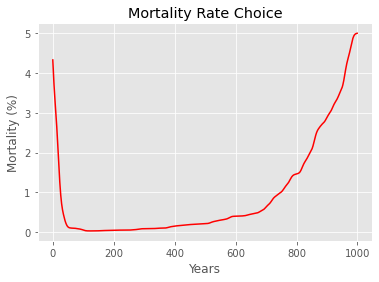

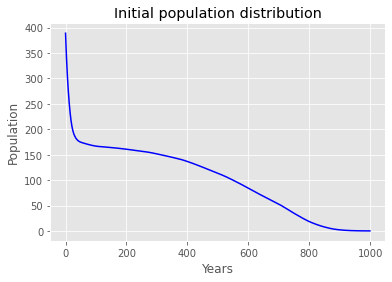

In [17]:
ages = handmade_astar_presim[0]
mortality = handmade_astar_presim[1]
pop_d = handmade_astar_presim[2]*1e5
fertility_start = 60
fertility_end = 180
flat_fertility_pdf = 0
sim_len = 3000
final_report = 1
special_step = np.arange(1,15,1)
savefile = None

handmade_astar_tfvsr = get_tf_vs_r(ages,mortality,pop_d,fertility_start,fertility_end,
                                      flat_fertility_pdf,
                                      sim_len,final_report,special_step,savefile)

### First custom data from plot_maker

Total population:  99999.99999999997
Birth rate:  0.004532962728574969
Death rate:  0.00423885925476891
Growth rate in percent:  0.02941034738060598
Estimated life expectancy after 1 year:  239.12231742021078
Astar-to-Human equiv:  23.912231742021078
Waith-to-Human equiv:  0.9564892696808431


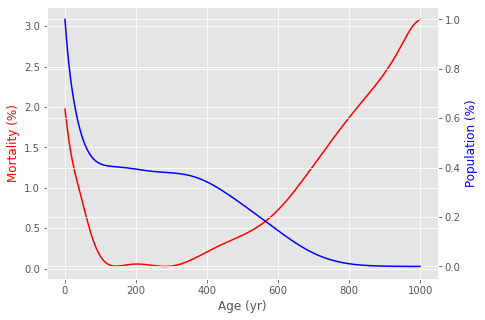

In [18]:
lower = 20
x_vals = [0.8064516129032242, 2.2177419354838683, 3.629032258064516, 5.846774193548384, 9.072580645161288, 13.911290322580644, 15.927419354838708, 18.951612903225804, 22.379032258064516, 23.18548387096774, 26.00806451612903, 30.040322580645157, 31.653225806451612, 33.46774193548387, 35.28225806451613, 36.89516129032258, 38.10483870967741, 40.927419354838705, 44.55645161290322, 47.177419354838705, 50.0, 53.427419354838705, 56.85483870967742, 59.677419354838705, 62.29838709677419, 65.52419354838709, 67.94354838709677, 70.16129032258064, 71.9758064516129, 75.0, 78.4274193548387, 82.45967741935483, 84.87903225806451, 86.89516129032258, 90.12096774193549, 92.94354838709677, 94.95967741935483, 96.57258064516128, 97.78225806451613, 98.99193548387096]
y_vals = np.array([52.543290043290064, 49.29653679653681, 42.26190476190477, 27.922077922077932, 24.134199134199143, 20.887445887445892, 21.15800865800867, 20.616883116883123, 20.887445887445892, 20.887445887445892, 21.15800865800867, 21.428571428571438, 21.428571428571438, 21.699134199134207, 22.78138528138529, 23.863636363636374, 24.67532467532468, 26.56926406926408, 27.922077922077932, 29.004329004329016, 30.627705627705637, 33.33333333333334, 36.30952380952382, 38.744588744588754, 41.991341991342004, 45.77922077922079, 49.56709956709958, 53.89610389610392, 57.14285714285716, 60.66017316017318, 66.07142857142858, 70.6709956709957, 74.45887445887448, 76.8939393939394, 82.03463203463207, 86.90476190476193, 91.23376623376626, 94.75108225108227, 96.3744588744589, 98.2683982683983])-lower


ages = x_vals
mortality = y_vals
lifetime = 1000
fertility_start = 60
fertility_end = 180
TF_guess = 5
curve_degree = 12
cohort_len = 1
flat_fertility_pdf = 0
customfactor = 5
verbose = 0
custom_01_all = pre_sim_process(ages,mortality,lifetime,fertility_start,fertility_end,
                                     TF_guess,curve_degree,cohort_len,flat_fertility_pdf,
                                     customfactor,verbose)

In [19]:

# #Astar Data, custom 0
# main_sim(first_custom_all[0],first_custom_all[1],120,320,population_distribution=np.zeros(len(first_custom_all[1]))+1e3
#          ,predict=1,guess_TF=3,set_growth_rate=(0.1/100),TF_set=5.53,sim_len=None,print_flag=0)


### Next Custom Data from plot_maker

Total population:  100000.00000000017
Birth rate:  0.004906708582941391
Death rate:  0.004273945989681243
Growth rate in percent:  0.06327625932601484
Estimated life expectancy after 1 year:  238.22620687596586
Astar-to-Human equiv:  23.822620687596586
Waith-to-Human equiv:  0.9529048275038634


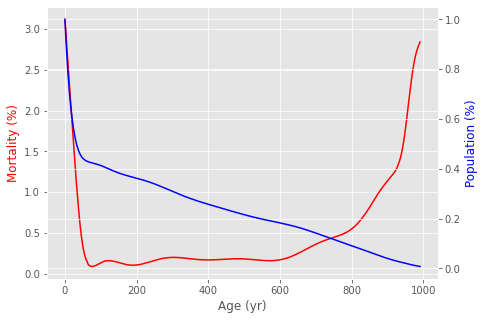

In [20]:
[x,y] = np.load('custom_2020-12-1319.01.17.480326.npy',allow_pickle=1)
y = np.array(y)-0

ages = x
mortality = y
lifetime = round(1000/len(x))*len(x)
fertility_start = 60
fertility_end = 180
TF_guess = 5.5
curve_degree = 12
cohort_len = 1
flat_fertility_pdf = 0
customfactor = 5
verbose = 0
custom_02_all = pre_sim_process(ages,mortality,lifetime,fertility_start,fertility_end,
                                     TF_guess,curve_degree,cohort_len,flat_fertility_pdf,
                                     customfactor,verbose)

In [21]:

# #Astar Data, custom 1
# main_sim(custom_all[0],custom_all[1],120,320,population_distribution=np.zeros(len(custom_all[1]))+1e3
#          ,predict=1,guess_TF=3,set_growth_rate=(0.1/100),TF_set=5.53,sim_len=None,print_flag=0)


### Custom 03

Total population:  100000.00000000015
Birth rate:  0.007681460871435579
Death rate:  0.007082952637033266
Growth rate in percent:  0.059850823440231266
Estimated life expectancy after 1 year:  145.1195234025649
Astar-to-Human equiv:  14.511952340256492
Waith-to-Human equiv:  0.5804780936102596


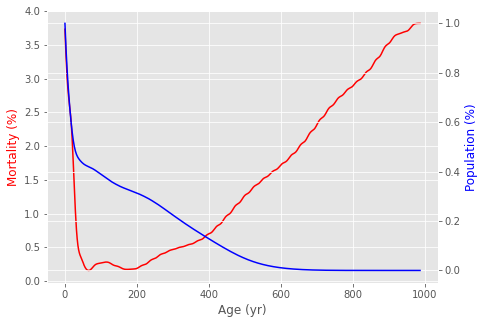

In [22]:
[x,y] = np.load('custom_2020-12-1322.27.51.312658.npy',allow_pickle=1)
y = np.array(y)-(0)

ages = x
mortality = y
lifetime = round(1000/len(x))*len(x)
fertility_start = 60
fertility_end = 180
TF_guess = 5.5
curve_degree = 12
cohort_len = 1
flat_fertility_pdf = 0
customfactor = 1
verbose = 0
custom_03_all = pre_sim_process(ages,mortality,lifetime,fertility_start,fertility_end,
                                     TF_guess,curve_degree,cohort_len,flat_fertility_pdf,
                                     customfactor,verbose)

In [23]:

# #Astar Data, custom 2
# main_sim(custom_2_all[0],custom_2_all[1],120,320,population_distribution=np.zeros(len(custom_2_all[1]))+1e3
#          ,predict=1,guess_TF=3,set_growth_rate=(0.1/100),TF_set=5.53,sim_len=None,print_flag=0)


### Custom 04

Total population:  99999.9999999999
Birth rate:  0.008833815885820996
Death rate:  0.006900012617036391
Growth rate in percent:  0.19338032687846052
Estimated life expectancy after 1 year:  149.34773705605141
Astar-to-Human equiv:  14.934773705605142
Waith-to-Human equiv:  0.5973909482242057


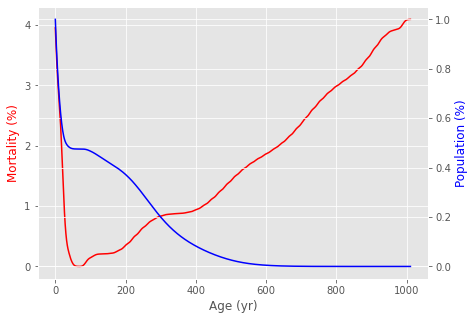

In [24]:
[x,y] = np.load('custom_2020-12-1322.35.05.227849.npy',allow_pickle=1)
y = np.array(y)-(9)

ages = x
mortality = y
lifetime = round(1000/len(x))*len(x)
fertility_start = 60
fertility_end = 180
TF_guess = 5.5
curve_degree = 12
cohort_len = 1
flat_fertility_pdf = 0
customfactor = 1
verbose = 0
custom_04_presim = pre_sim_process(ages,mortality,lifetime,fertility_start,fertility_end,
                                     TF_guess,curve_degree,cohort_len,flat_fertility_pdf,
                                     customfactor,verbose)

In [25]:
# #Astar Data, custom 3
# main_sim(custom_3_all[0],custom_3_all[1],60,180,population_distribution=np.zeros(len(custom_3_all[1]))+1e3
#          ,predict=1,guess_TF=3,set_growth_rate=(0.04/100),TF_set=5.53,sim_len=None,print_flag=0,flat_fertility_pdf=0,savefile=None)


In [4]:
custom_3_result = np.load('custom3_main2021-04-0923.20.08.076303.npy',allow_pickle=1)

pop_result = custom_3_result
pop_presim = custom_3_all
init_pop = 1e5
lifetime = 1000
total_war_casualties = init_pop*0.1*0.05
average_warrior_age = 50
warrior_age_spread = 20
recovery_time = 25
fertility_start = 60
fertility_end = 180
birth_rate_mod = 0
final_report=0

war_recovery(pop_result,pop_presim,init_pop,lifetime,total_war_casualties,average_warrior_age,warrior_age_spread,recovery_time,fertility_start,fertility_end,birth_rate_mod,final_report)

NameError: name 'custom_3_all' is not defined

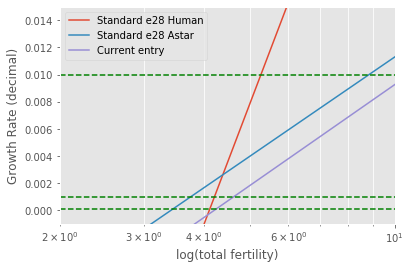

In [141]:
ages = custom_04_presim[0]
mortality = custom_04_presim[1]
pop_d = custom_04_presim[2]*1e5
fertility_start = 60
fertility_end = 180
flat_fertility_pdf = 0
sim_len = 3000
final_report = 1
special_step = np.arange(1,15,1)
savefile = None#"tfvsr_custom04_"

custom_04_tfvsr = get_tf_vs_r(ages,mortality,pop_d,fertility_start,fertility_end,
                                      flat_fertility_pdf,
                                      sim_len,final_report,special_step,savefile)

### Custom 05

Total population:  100000.00000000007
Birth rate:  0.012528166059187265
Death rate:  0.00627027549547272
Growth rate in percent:  0.6257890563714545
Estimated life expectancy after 1 year:  163.80164234591922
Astar-to-Human equiv:  16.380164234591923
Waith-to-Human equiv:  0.6552065693836769


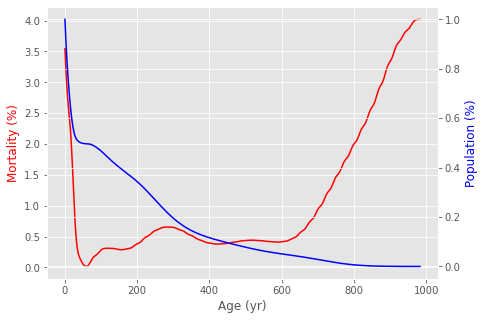

In [6]:
[x,y] = np.load('custom_2020-12-1322.39.07.306596.npy',allow_pickle=1)
y = np.array(y)-(0)

ages = x
mortality = y
lifetime = round(1000/len(x))*len(x)
fertility_start = 60
fertility_end = 180
TF_guess = 8.5
curve_degree = 12
cohort_len = 1
flat_fertility_pdf = 0
customfactor = 1
verbose = 0
custom_05_presim = pre_sim_process(ages,mortality,lifetime,fertility_start,fertility_end,
                                     TF_guess,curve_degree,cohort_len,flat_fertility_pdf,
                                     customfactor,verbose)

In [28]:
# astar_custom_4_1_result = np.load('astar_custom_4_1_2020-12-1419.19.01.761650.npy',allow_pickle=1)

#astar_custom_4_1_result[2]
# #Astar Data, custom 4
# main_sim(custom_4_all[0],custom_4_all[1],120,320,population_distribution=(astar_custom_4_1_result[0]*1e5)
#          ,predict=1,guess_TF=3,set_growth_rate=(0.04/100),TF_set=5.496,sim_len=1000,print_flag=0,savefile="custom_4_main_01_")


In [8]:
pop_result = np.load('custom_4_main_01_2021-04-0923.27.24.571173.npy',allow_pickle=1)
pop_presim = custom_4_all
init_pop = 1e5
lifetime = 1000
total_war_casualties = init_pop*0.1*0.5
average_warrior_age = 200
warrior_age_spread = 80
recovery_time = 105
fertility_start = 120
fertility_end = 320
birth_rate_mod = -0.2
final_report=1

war_recovery(pop_result,pop_presim,init_pop,lifetime,total_war_casualties,average_warrior_age,warrior_age_spread,recovery_time,fertility_start,fertility_end,birth_rate_mod,final_report)

NameError: name 'custom_4_all' is not defined

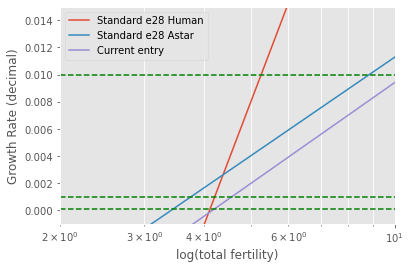

In [35]:
ages = custom_05_presim[0]
mortality = custom_05_presim[1]
pop_d = custom_05_presim[2]*1e5
fertility_start = 60
fertility_end = 180
flat_fertility_pdf = 0
sim_len = 3000
final_report = 1
special_step = np.arange(1,15,1)
savefile = "tfvsr_custom05_"

custom_05_tfvsr = get_tf_vs_r(ages,mortality,pop_d,fertility_start,fertility_end,
                                      flat_fertility_pdf,
                                      sim_len,final_report,special_step,savefile)

In [23]:
tfr_custom5 = np.load('tfvsr_custom05_2021-04-2014.43.26.131133.npy',allow_pickle=1)
(tfr_custom5[0]*np.log(5)+tfr_custom5[1])*100

0.19718916585779872

## Cusotm 6

In [30]:
#from poppyr_header import pre_sim_process
%run poppyr_header.py

Total population:  99999.99999999981
Birth rate:  0.0043732360074190514
Death rate:  0.004049621907227823
Growth rate in percent:  0.03236141001912285
Estimated life expectancy after 1 year:  250.91118495804588
Astar-to-Human equiv:  25.09111849580459
Waith-to-Human equiv:  1.0036447398321835


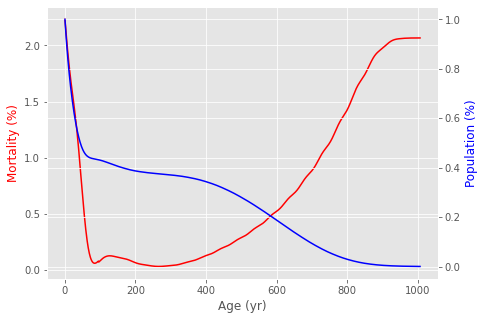

In [37]:
[x,y] = np.load('astar_custom6_2022-08-2910.39.46.772773.npy',allow_pickle=1)
y = np.array(y)-(0)

x = x[:-1]
y = y[:-1]

ages = x
mortality = y
lifetime = round(1000/len(x))*len(x)
fertility_start = 60
fertility_end = 180
TF_guess = 5
curve_degree = 3
cohort_len = 1
flat_fertility_pdf = 0
customfactor = 5
verbose = 0
custom_06_presim = pre_sim_process(ages,mortality,lifetime,fertility_start,fertility_end,
                                     TF_guess,curve_degree,cohort_len,flat_fertility_pdf,
                                     customfactor,verbose)

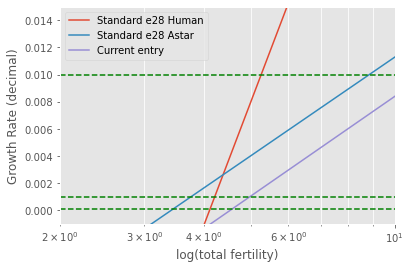

In [38]:
ages = custom_06_presim[0]
mortality = custom_06_presim[1]
pop_d = custom_06_presim[2]*1e5
fertility_start = 60
fertility_end = 180
flat_fertility_pdf = 0
sim_len = 3000
final_report = 1
special_step = np.arange(1,15,1)
savefile = "tfvsr_custom06_"

custom_06_tfvsr = get_tf_vs_r(ages,mortality,pop_d,fertility_start,fertility_end,
                                      flat_fertility_pdf,
                                      sim_len,final_report,special_step,savefile)

### Waith

/home/soundofives/Documents/DND/dnd-progs/poppyr_header.py:58: RankWarning: Polyfit may be poorly conditioned
  abb_mortality = get_curve(ages,len(ages),mortality,deg=curve_degree)


Total population:  99999.99999993833
Birth rate:  6.015518735147892e-05
Death rate:  1.7583993837846734e-08
Growth rate in percent:  0.006013760335764107
Estimated life expectancy after 1 year:  25000.00000000729
Astar-to-Human equiv:  2500.0000000007294
Waith-to-Human equiv:  100.00000000002916


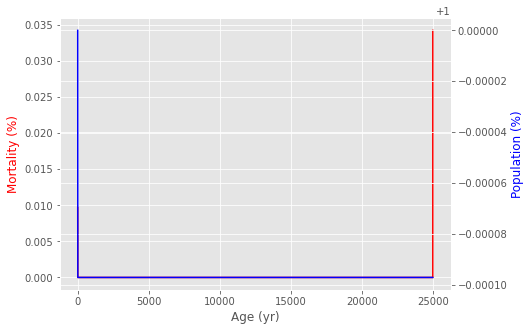

In [26]:
#[x,y] = np.load('custom_2020-12-1322.46.24.823260.npy',allow_pickle=1)
[x,y] = np.load('waith_lowchildmort_01_2022-07-0613.54.39.915369.npy',allow_pickle=1)
y = np.array(y)
y[0] = y[0]

ages = x
mortality = y
lifetime = round(25000/len(x))*len(x)
fertility_start = 500
fertility_end = 3500
TF_guess = 3.008
curve_degree = 11
cohort_len = 1
flat_fertility_pdf = 0
customfactor = 0.00001
verbose = 0
waith_presim = pre_sim_process(ages,mortality,lifetime,fertility_start,fertility_end,
                                     TF_guess,curve_degree,cohort_len,flat_fertility_pdf,
                                     customfactor,verbose)

In [40]:
savefile = "waith_presim_"
np.save(savefile+str(dt.datetime.now()).strip().replace(' ','').replace(':','.')
                ,waith_presim,allow_pickle=1)

In [12]:
waith_presim = np.load('waith_presim_2022-07-0610.26.35.703306.npy',allow_pickle=1)

In [38]:
[x,y] = np.load('custom_2020-12-1322.46.24.823260.npy',allow_pickle=1)
y = np.array(y)
y[0] = y[0]

ages = x
mortality = y
lifetime = round(25000/len(x))*len(x)
fertility_start = 500
fertility_end = 3500
TF_guess = 3.008
curve_degree = 12
cohort_len = 1
flat_fertility_pdf = 0
customfactor = 0.001
verbose = 0
waith_presim_2 = pre_sim_process(ages,mortality,lifetime,fertility_start,fertility_end,
                                     TF_guess,curve_degree,cohort_len,flat_fertility_pdf,
                                     customfactor,verbose)

KeyboardInterrupt: 

Final growth rate:  0.01 %
Final birth rate:  0.0002560621352008768
Final death rate:  0.0001558236834358168
Final population:  2969648.4299466815
Half population below:  3657  years
Half pop below (astar):  365.70000000000005
Half pop below (waith):  14.628
TF final value:  3.692073500757376


NameError: name 'iterator' is not defined

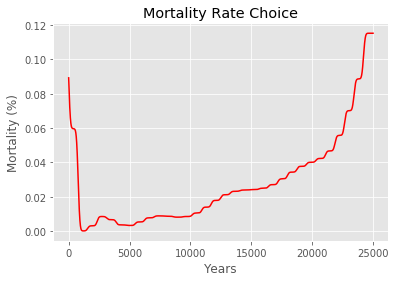

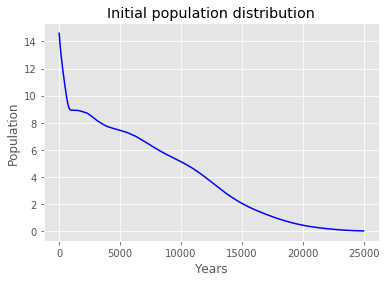

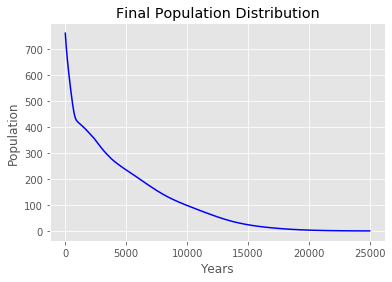

In [6]:
# #Waith
ages = waith_presim[0]
mortality = waith_presim[1]
pop_d = waith_presim[2]*1e5
fertility_start = 500
fertility_end = 3500
predict_TF = 1
guess_TF = 3
set_growth_rate = (0.02/100)
set_TF = 5.67
flat_fertility_pdf = 0
sim_len = 50000
print_flag = 0
final_report = 1
savefile = "waith_mainsim_"

waith_mainsim = main_sim(ages,mortality,pop_d,fertility_start,fertility_end,
                                  predict_TF,guess_TF,set_growth_rate,set_TF,flat_fertility_pdf,
                                  sim_len,print_flag,final_report,savefile)
#[final_pop_d,pop_d,half_pop_below,TF,growth_rate,birth_rate,death_rate]

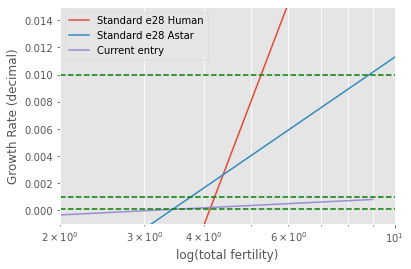

In [13]:
ages = waith_presim[0]
mortality = waith_presim[1]
pop_d = waith_presim[2]*1e5
fertility_start = 500
fertility_end = 3500
flat_fertility_pdf = 0
sim_len = 50000
final_report = 1
special_step = np.arange(1,10,1)
savefile = "tfvsr_waith_1_"

waith_tfvsr = get_tf_vs_r(ages,mortality,pop_d,fertility_start,fertility_end,
                                      flat_fertility_pdf,
                                      sim_len,final_report,special_step,savefile)

### Zero mortality test

In [ ]:
[x,y] = np.load('custom_2020-12-1322.39.07.306596.npy',allow_pickle=1)
y = np.array(y)-(100)
zero_death_all = pre_sim_process(x,y,1000,fertility_start=120,fertility_end=320
                                  ,TF_guess=3,curve_degree=12,verbose=0,plot=0)

In [ ]:

# #Zero mortality test
# main_sim(zero_death_all[0],zero_death_all[1],120,320,population_distribution=np.zeros(len(zero_death_all[1]))+1e3
#          ,predict=0,guess_TF=3,set_growth_rate=(0.001/100),TF_set=3,sim_len=1200,print_flag=0)


### Low Child Mortality Astar - Custom 06

Total population:  100000.00000000013
Birth rate:  0.003553661961978573
Death rate:  0.0025831723796345507
Growth rate in percent:  0.09704895823440221
Estimated life expectancy after 1 year:  389.24919047190673
Astar-to-Human equiv:  38.92491904719068
Waith-to-Human equiv:  1.556996761887627


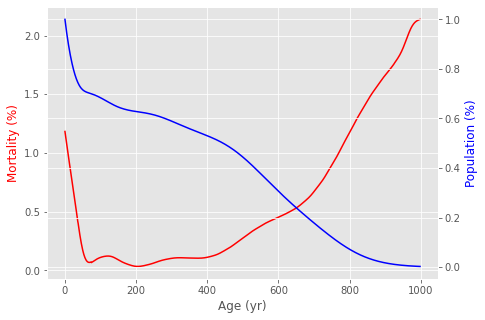

In [9]:
[x,y] = np.load('astar_lowchildmort_01_2021-04-1721.04.08.248336.npy',allow_pickle=1)

ages = x
mortality = y
lifetime = round(1000/len(x))*len(x)
fertility_start = 60
fertility_end = 180
TF_guess = 4
curve_degree = 12
cohort_len = 1
flat_fertility_pdf = 0
customfactor = 5
verbose = 0
astar_lowchildmort_presim = pre_sim_process(ages,mortality,lifetime,fertility_start,fertility_end,
                                     TF_guess,curve_degree,cohort_len,flat_fertility_pdf,
                                     customfactor,verbose)

Final growth rate:  0.1 %
Final birth rate:  0.003452281153885409
Final death rate:  0.002450353424099975
Final population:  3345498.9395474335
Half population below:  232  years
Half pop below (astar):  23.200000000000003
Half pop below (waith):  0.928
TF final value:  3.1871932739841933


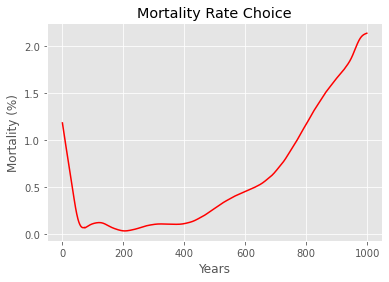

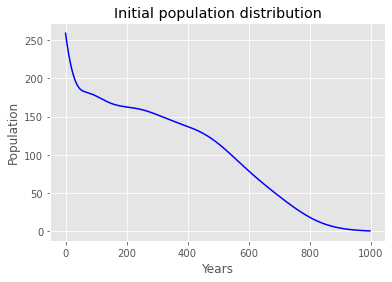

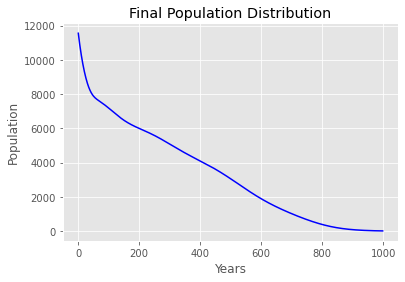

In [10]:
# #Astar low child mortality Data
ages = astar_lowchildmort_presim[0]
mortality = astar_lowchildmort_presim[1]
pop_d = astar_lowchildmort_presim[2]*1e5
fertility_start = 60
fertility_end = 180
predict_TF = 1
guess_TF = 5
set_growth_rate = (0.1/100)
set_TF = 5.67
flat_fertility_pdf = 0
sim_len = 2000
print_flag = 0
final_report = 1
savefile = None

astar_lowchildmort_mainsim = main_sim(ages,mortality,pop_d,fertility_start,fertility_end,
                                  predict_TF,guess_TF,set_growth_rate,set_TF,flat_fertility_pdf,
                                  sim_len,print_flag,final_report,savefile)
#[final_pop_d,pop_d,half_pop_below,TF,growth_rate,birth_rate,death_rate]

100.81377467432176

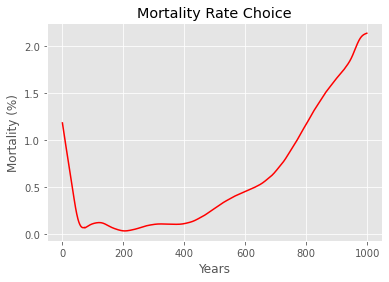

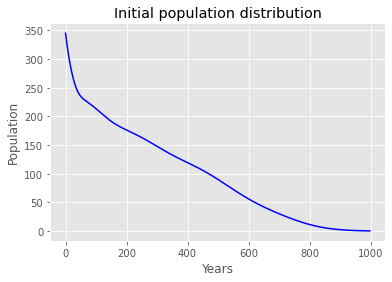

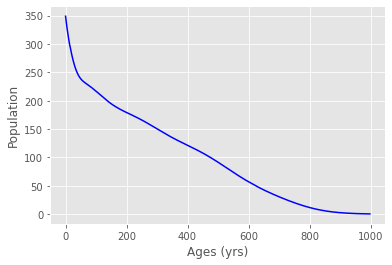

In [11]:
pop_mainsim = astar_lowchildmort_mainsim
pop_presim = astar_lowchildmort_presim
init_pop = 1e5
lifetime = round(1000/len(x))*len(x)
total_war_casualties = init_pop*0.1*0.25*0.5
average_warrior_age = 300
warrior_age_spread = 250
recovery_time = 15
fertility_start = 60
fertility_end = 180
birth_rate_mod = -0
final_report=0

war_recovery(pop_mainsim,pop_presim,init_pop,lifetime,total_war_casualties,
             average_warrior_age,warrior_age_spread,recovery_time,
             fertility_start,fertility_end,birth_rate_mod,final_report)

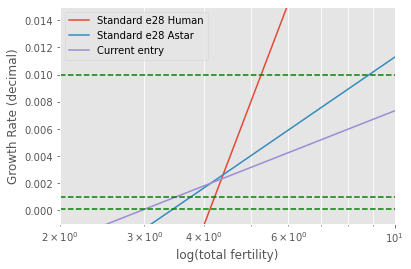

In [12]:
ages = astar_lowchildmort_presim[0]
mortality = astar_lowchildmort_presim[1]
pop_d = astar_lowchildmort_presim[2]*1e5
fertility_start = 60
fertility_end = 500
flat_fertility_pdf = 0
sim_len = 3000
final_report = 1
special_step = np.arange(1,15,1)
savefile = None#"tfvsr_astarlowchildmort_"

astar_lowchildmort_tfvsr = get_tf_vs_r(ages,mortality,pop_d,fertility_start,fertility_end,
                                      flat_fertility_pdf,
                                      sim_len,final_report,special_step,savefile)

## Deriving mortality from life table

In [13]:
#from poppyr_header import pre_sim_process
%run poppyr_header.py

[ 48.09398281   5.30448438   3.09563295   5.00095075   7.60608487
   8.70883882   8.99383009   9.30899609   9.40195515  10.18724215
  11.20141343  13.21130123  19.30307199  28.125       40.31620553
  50.99337748  62.16216216 100.        ]


KeyboardInterrupt: 

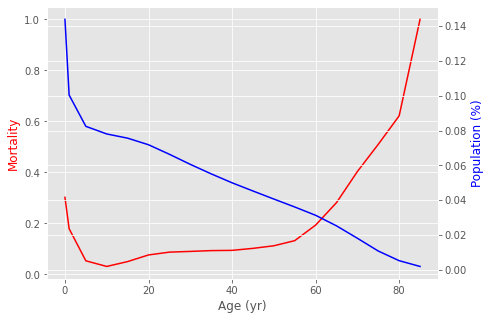

In [14]:
stnd_e28_table = np.array([10000,6980,5731,5427,5259,4996,4616,4214,3835,3478,3151,2830,2513,2181,1760,1265,755,370,140])
stnd_e28_ages = np.arange(0,90,5)
stnd_e28_ages = np.insert(stnd_e28_ages,1,1)

stnd_e28_mortality = get_mortality_from_lifetable(stnd_e28_ages,stnd_e28_table,plot=1)*100
stnd_e28_merge_youth = np.sum(stnd_e28_mortality[0:2])
stnd_e28_mortality = np.delete(stnd_e28_mortality,[0,1])
stnd_e28_mortality = np.insert(stnd_e28_mortality,0,stnd_e28_merge_youth)
stnd_e28_ages = np.arange(0,90,5)
print(stnd_e28_mortality)

ages = stnd_e28_ages
mortality = stnd_e28_mortality

# lifetime = round(1000/len(stnd_e28_ages))*len(stnd_e28_ages)
# fertility_start = 60
# fertility_end = 180
# TF_guess = 4.5
# curve_degree = 12
# cohort_len = 1
# flat_fertility_pdf = 0
# customfactor = 8
# verbose = 0

lifetime = round(25000/len(stnd_e28_ages))*len(stnd_e28_ages)
fertility_start = 2000
fertility_end = 5000
TF_guess = 4.5
curve_degree = 12
cohort_len = 1
flat_fertility_pdf = 0
customfactor = 8
verbose = 0

stnd_e28_presim = pre_sim_process(ages,mortality,lifetime,fertility_start,fertility_end,
                                     TF_guess,curve_degree,cohort_len,flat_fertility_pdf,
                                     customfactor,verbose)

#[ages_final,mortality_final,I,d,e,[pop,total_deaths,new_births,r],lifetable]
stnd_e28_presim[-1].transpose()[0:10]

Final growth rate:  0.08 %
Final birth rate:  0.003882731027678329
Final death rate:  0.0030798451055640366
Final population:  466010.01255236135
Half population below:  238  years
Half pop below (astar):  23.8
Half pop below (waith):  0.9520000000000001
TF final value:  3.846896984277142


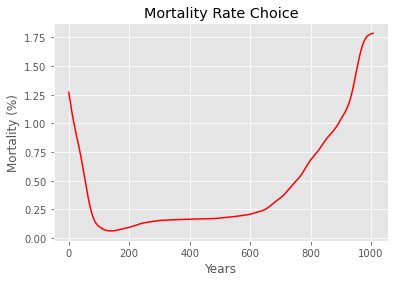

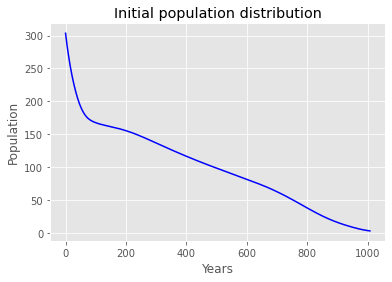

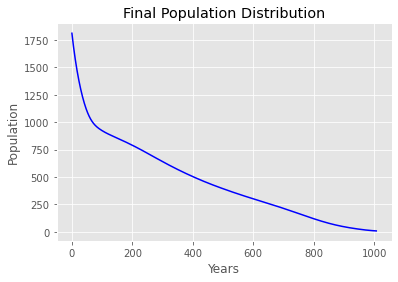

In [16]:
#Mainsim for stnd_e28
ages = stnd_e28_presim[0]
mortality = stnd_e28_presim[1]
pop_d = stnd_e28_presim[2]*1e5
fertility_start = 60
fertility_end = 180#180
predict_TF = 1
guess_TF = 4
set_growth_rate = (0.08/100)
set_TF = 3 #np.arange(0.1,15,0.1)
flat_fertility_pdf = 0
sim_len = 2000
print_flag = 0
final_report = 1
savefile = None

# r_array = []
# for i in range(0,len(set_TF)):
#     pop_d = stnd_e28_presim[2]*1e5
stnd_e28_mainsim = main_sim(ages,mortality,pop_d,fertility_start,fertility_end,
                                  predict_TF,guess_TF,set_growth_rate,set_TF,flat_fertility_pdf,
                                  sim_len,print_flag,final_report,savefile)
    #[final_pop_d,pop_d,half_pop_below,TF,growth_rate,birth_rate,death_rate]
#     r_array.append(stnd_e28_mainsim[4])
#     clear_output()
#     plt.close('all')
# fit = np.polyfit(np.log(set_TF),r_array,1)
# curve = np.poly1d(fit)
# np.save("tfvsr_stnde28_astar_"+str(dt.datetime.now()).strip().replace(' ','').replace(':','.')
#                 ,curve,allow_pickle=1)

# Exponential Growth Calculation

In [9]:
init_pop = 19e6
#g_rate_Human = 0.0004
#g_rate_Astar = 0.0000639
#g_rate_Waith = 0.0000007

#If we go based on proportions of human generations:
#g_rate_Human = 0.04/100 #gen 27 years
#g_rate_Astar = 0.00009 #gen 120 years
#g_rate_Waith = 0.0000054 #gen 2000 years

#Natural growth if no limiting factors: 1/100
#Only passes through women, 50% of pop
#Only passes through women who live to maturity, 50% of pop

g_rate_kosm = 0.25/100

exp_fun = lambda init_pop,g_rate,x: init_pop*np.exp(g_rate*x)

num_years = 2000
xarray = np.linspace(0,num_years,100)
#plt.plot(xarray,exp_fun(xarray))

rate_choice = 0.07/100
print("Total number lived in those years: ",sum(exp_fun(init_pop,rate_choice,xarray)))
print("Number alive at the end of those years: ","{:e}".format(np.round(exp_fun(init_pop,rate_choice,xarray)[-1],0)))
print("Growth: ","{:e}".format(np.round(exp_fun(init_pop,rate_choice,xarray)[-1] - init_pop)))

Total number lived in those years:  4152972191.15793
Number alive at the end of those years:  7.704880e+07
Growth:  5.804880e+07


In [3]:
#cultures and their growth rates for 

In [4]:
kosm_function(2000)

NameError: name 'kosm_function' is not defined

In [5]:
fertility_start = 18
fertility_end = 45
cohort_size = 1
placeholder = 1
TF = 3
spreadfactor = 2

num_fertile_cohorts = int((fertility_end-fertility_start)/cohort_size)
xarray = np.linspace(fertility_start,fertility_end,num_fertile_cohorts)

average_age = (fertility_start+fertility_end)/2
spread = (1/spreadfactor)*(average_age-fertility_start)
print(spread)

a = (placeholder/(spread*np.sqrt(2*np.pi)))
pdf = gauss(xarray,a,average_age,spread)
skewness = -(0.5*spreadfactor)*spread/(average_age)
pdf_sk = gauss(xarray*skewness,a,average_age,spread)
pdf_zero = gauss(0,a,average_age,spread)
pdf_skewed = pdf*pdf_sk/pdf_zero

pdf_skewed_norm = pdf_skewed/sum(pdf_skewed)
print(sum(TF*pdf_skewed_norm))

straightline = np.linspace(1,1,len(xarray))*(TF/num_fertile_cohorts)
print(sum(straightline))

plt.plot(xarray,TF*pdf_skewed_norm)
plt.plot(xarray,straightline)

6.75


NameError: name 'gauss' is not defined

In [15]:
np.ndarray([degrees.shape])

TypeError: ndarray() missing required argument 'shape' (pos 1)

In [106]:
quad = lambda x: x**2 / 1000 + 1
dipole = lambda theta,l: 1*(3*np.cos(theta)*np.sin(theta))/(l**3)


degrees = np.linspace(0.001,89.999,180)*(np.pi/180)
distance = np.linspace(0.1,0.12,1000)
lines = np.ndarray([degrees.shape[-1],distance.shape[-1]])
for deg in range(0,len(degrees)):
    for dist in range(0,len(distance)):
        lines[deg][dist] = dipole(degrees[deg],distance[dist])

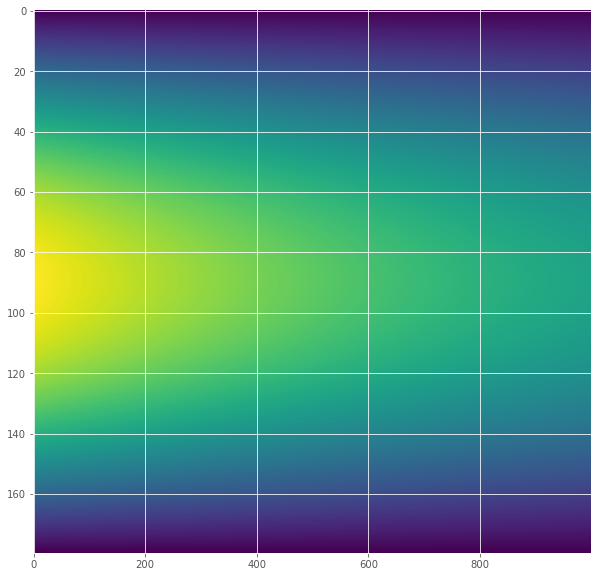

In [107]:
plt.figure(figsize=[10,10])
plt.imshow(lines,aspect='auto')

In [59]:
from sklearn.preprocessing import MinMaxScaler

In [108]:
n = 1/lines[:,0]
scaler = MinMaxScaler()
n = scaler.fit_transform(n.reshape(1,-1).T).flatten()

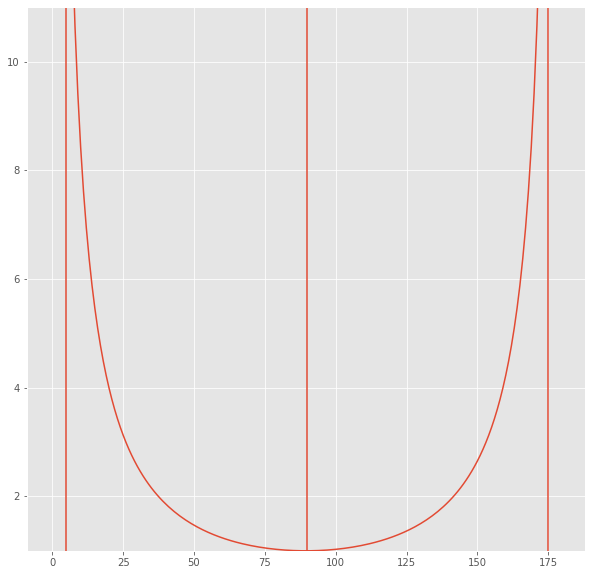

In [113]:
plt.figure(figsize=[10,10])
plt.plot(45000*n+1)
plt.ylim(1,1+10)
plt.axvline(5)
plt.axvline(90)
plt.axvline(175)

In [119]:
nn = 45000*n+1
nn[177]

44.14638448247798